# Full FEE

### Detailed model of the PMT plane front-end electronics

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

In [5]:
import Core.system_of_units as units

In [6]:
import time

In [7]:
import Sierpe.FEE as FE

In [8]:
import tables

In [9]:
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [10]:
import Core.fit_library as fit

In [11]:
import Core.coreFunctions as crf

## Revised on:

In [12]:
print(time.strftime("%d/%m/%Y"))

18/11/2016


In [13]:
print(time.strftime("%H:%M:%S"))

14:30:38


In [14]:
!/Users/jjgomezcadenas/anaconda2/bin/pep8 ../../Sierpe/FEE.py

In [15]:
!/Users/jjgomezcadenas/anaconda2/bin/pyflakes ../../Sierpe/FEE.py

## Testing

In [16]:
from nose.tools import *

### Values of global parameters

In [19]:
def test_fee_params():
    """
    Check the values of the FEE params
    """
    assert_equal(FE.PMT_GAIN, 1.7e6)
    assert_equal(FE.FEE_GAIN, 582.237*units.ohm)
    assert_equal(FE.DAQ_GAIN, 1.25)
    assert_equal(FE.NBITS, 12)
    assert_equal(FE.LSB, 2.0*units.V/2**FE.NBITS/FE.DAQ_GAIN)
    assert_equal(FE.NOISE_I, FE.LSB/(FE.FEE_GAIN*FE.DAQ_GAIN))
    assert_equal(FE.NOISE_DAQ, 0.313*units.mV)
    assert_equal(FE.C2, 8*units.nF)
    assert_equal(FE.C1, 2714*units.nF)
    assert_equal(FE.R1, 1567*units.ohm)
    assert_equal(FE.Zin, 62*units.ohm)
    assert_equal(FE.t_sample, 25*units.ns)
    assert_equal(FE.f_sample, 1./FE.t_sample)
    assert_equal(FE.f_mc, 1./(1*units.ns))
    assert_equal(FE.f_LPF1, 3*units.MHZ)
    assert_equal(FE.f_LPF2, 10*units.MHZ)
    #assert_equal(FE.ADC_TO_PES, 24)  # nominal factor, comes out from spe area
    assert_equal(FE.OFFSET, 2500)  # offset adc
    print('test passed')

In [20]:
test_fee_params()
    
        

test passed


### SPE

Class SPE models a single photoelectron in the PMT (represents a delta by a narrow trapezoid)

#### SPE instance

In [21]:
spe = FE.SPE()

In [22]:
spe


        (PMT gain = 1.7e+06, amplitude =    45 muA
         slope =  5.00 ns, flat =  1.00 ns)
        

### SPE in adc counts

In [29]:
def spe_adc():
    """
    Check the values of the FEE params
    """
    ipmt = 0
    spe = FE.SPE()
    fee = FE.FEE(noise_FEEPMB_rms=0*units.mA, noise_DAQ_rms=0)
    assert_equal(FE.PMT_GAIN, 1.7e6)
    spe_i = FE.spe_pulse(spe,t0=100*units.ns, tmax=200*units.ns)
    spe_v = FE.signal_v_fee(fee, spe_i,ipmt)
    spe_v_lpf = FE.signal_v_lpf(fee, spe_i)
    spe_adc = FE.daq_decimator(1000.*units.MHZ, 40*units.MHZ, spe_v*FE.v_to_adc())
    spe_adc_lpf = FE.daq_decimator(1000.*units.MHZ, 40*units.MHZ, spe_v_lpf*FE.v_to_adc())
    adc_to_pes = np.sum(spe_adc[3:7])
    adc_to_pes_lpf = np.sum(spe_adc_lpf[3:7])
    #assert_greater(adc_to_pes, 18)
    #assert_less(adc_to_pes, 22)
    print('adc_to_pes = {} adc_to_pes_lpf = {}'.format(adc_to_pes, adc_to_pes_lpf))
    
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(spe_i*FE.i_to_v()/units.mV)
    plt.subplot(3, 2, 2)
    plt.plot(spe_v/units.mV)
    plt.subplot(3, 2, 3)
    plt.plot(spe_v_lpf/units.mV)
    plt.subplot(3, 2, 4)
    plt.plot(spe_adc)
    plt.subplot(3, 2, 5)
    plt.plot(spe_adc_lpf)
    plt.show()
    

adc_to_pes = 23.0677051472 adc_to_pes_lpf = 24.0906909929


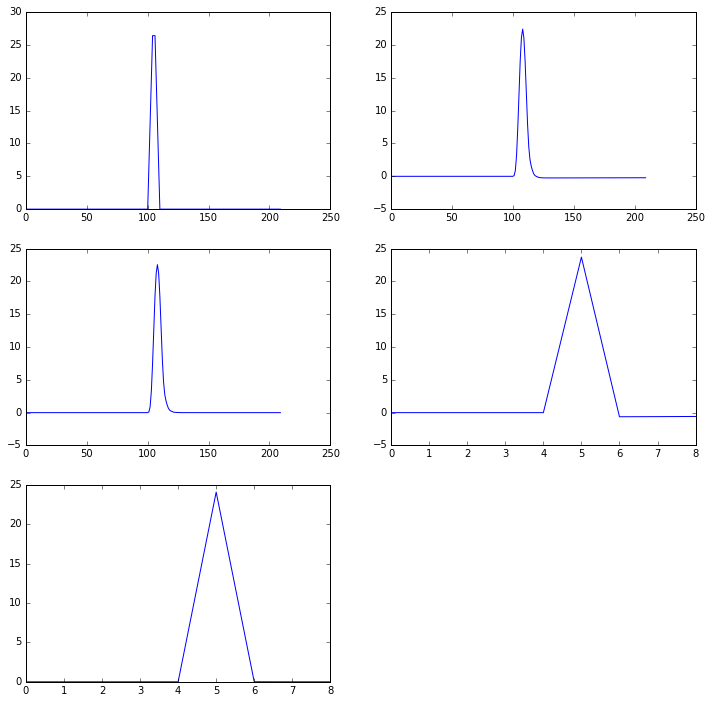

In [30]:
spe_adc()

### SPE functions

1. *spe_pulse(spe,t0=100*units.ns, tmax=1e+6*units.ns, time_step=1*units.ns)*: generates a spe pulse between t0 and tmax in units of t_step

2. *spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus, time_step=1*units.ns)*:  generates a train of spe pulses between signal_start and (start+ length), in the window daq_window
   
3. *spe_pulse_from_vector(spe,cnt)*: Returns a train of SPE pulses corresponding to vector cnt

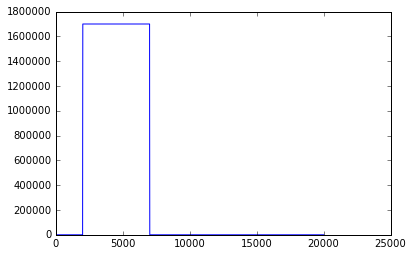

In [27]:
plt.plot(FE.spe_pulse_train(spe,signal_start=2000*units.ns,signal_length=5000*units.ns, daq_window=20*units.mus))

In [28]:
cnt = np.random.poisson(5, 10000)

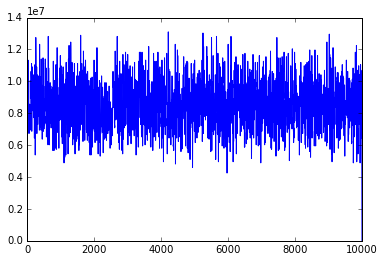

In [29]:
plt.plot(FE.spe_pulse_from_vector(spe,cnt))

## Full FEE model

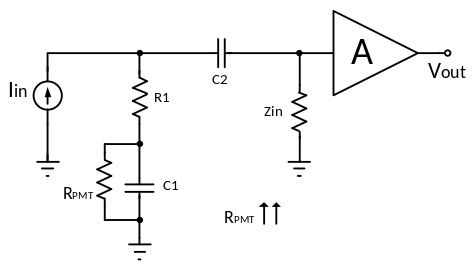

In [30]:
PATH = "../../LabTools/Rpar_Images/"; Image(filename = PATH + "FEE_PMT.png")

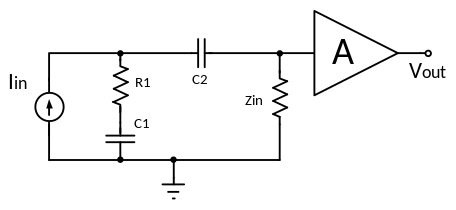

In [300]:
Image(filename = PATH + "FEE_PMT_simple.png")

In [329]:
# globals describing FEE
PMT_GAIN = 1.7e6
FEE_GAIN = 582.237*units.ohm
DAQ_GAIN = 1.25
NBITS = 12
LSB = 2.0*units.V/2**NBITS/DAQ_GAIN
NOISE_I = LSB/(FEE_GAIN*DAQ_GAIN)
NOISE_DAQ = 0.313*units.mV

C2 = 8*units.nF
C1 = 2714*units.nF
R1 = 1567*units.ohm
Zin = 62*units.ohm
t_sample = 25*units.ns
f_sample = 1./t_sample
f_mc = 1./(1*units.ns)
f_LPF1 = 3*units.MHZ
f_LPF2 = 10*units.MHZ
ADC_TO_PES = 20  # nominal factor, comes out from spe area
OFFSET = 2500  # offset adc
CEILING = 4096  # ceiling of adc

R = R1 + Zin
Cr = 1. + C1/C2
C = C1/Cr
freq_LHPF = 1./(R * C)
freq_LHPFd = freq_LHPF/(f_sample*np.pi)
c_blr=freq_LHPFd*np.pi
c_blr_app=1./(R1 * C2* f_sample)
print('c_blr = {}'.format(c_blr))
print('approx c_blr = {}'.format(c_blr_app))

freq_zero = 1./(R1*C1)
coeff_c = freq_zero/(f_sample*np.pi)
print('c_clean = {}'.format(coeff_c))

C1_ = (c_blr_app/coeff_c)*(C2/np.pi)
print('C1 = {} nF, C1_ = {} nF'.format(C1/units.nF, C1_/units.nF))

R1_ = 1./(C1_*coeff_c*f_sample*np.pi)
print('R1 = {} ohm, R1_ = {} ohm'.format(R1/units.ohm, R1_/units.ohm))

A1 = R1 * Zin/(R1 + Zin)  # ohms
A1_ = R1_ * Zin/(R1_ + Zin)  # ohms
A2 = FEE_GAIN/A1   # ohms/ohms = []
A2_ = FEE_GAIN/A1_  # ohms/ohms = []
Cr = 1. + C1/C2
Cr_ = 1. + C1_/C2
ZC = Zin/Cr
ZC_ = Zin/Cr_    

print('nominal A1 = {} ohm, A1_ = {} ohm'.format(A1/units.ohm, A1_/units.ohm))
print('nominal A2 = {}, A2_ = {} '.format(A2, A2_))
print('nominal Cr = {} ohm, Cr_ = {} ohm'.format(Cr, Cr_))
print('nominal ZC = {} ohm, ZC_ = {} ohm'.format(ZC/units.ohm, ZC_/units.ohm))


c_blr = 0.00192400951255
approx c_blr = 0.00199425654116
c_clean = 1.87116159952e-06
C1 = 2714.0 nF, C1_ = 2714.0 nF
R1 = 1567.0 ohm, R1_ = 1567.0 ohm
nominal A1 = 59.6402701044 ohm, A1_ = 59.6402701044 ohm
nominal A2 = 9.76248093748, A2_ = 9.76248093748 
nominal Cr = 340.25 ohm, Cr_ = 340.25 ohm
nominal ZC = 0.18221895665 ohm, ZC_ = 0.18221895665 ohm


In [322]:
%%latex

$c_b$~is the value of the deconvolution coefficient that enters the accumulator
\[
c_b = \frac{1}{R C} \frac{1}{f_s} 
\]
\[
    R = R_1 + Z_{in} \sim R_1
\]
\[
    C = \frac{C_1}{1 + \frac{C1}{C2}} \sim C_2
\]
\[
    c_b \sim \frac{1}{R_1 C_2}\frac{1}{f_s}
\]
\[
    c_c = \frac{1}{R_1 C_1 f_s \pi}
\]
\[
    \frac{c_b}{c_c} = \frac{C_1}{C_2}\pi
\]


<IPython.core.display.Latex object>

In [325]:
%%latex
\[
    C_1 = \frac{c_b}{c_c}\frac{C_2}{\pi}
\]
\[
    R_1 = \frac{1}{c_c C_1 f_s \pi}
\]

<IPython.core.display.Latex object>

In [308]:
def cb(R,C,fs):
    """
    Deconvolution coefficient (accumulator) in terms of RC
    """
    return 1./(R*C*fs)

## ==== NOISE MODEL (PMT AND FEE are combined) ====

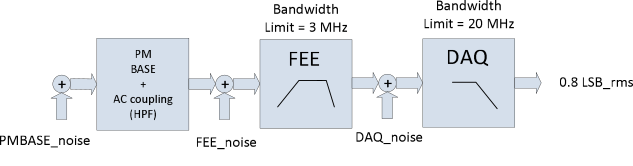

In [31]:
PATH = "../../LabTools/Rpar_Images/"; Image(filename = PATH + "NOISE.png")

$$ GAIN=FEE_{GAIN} \times DAQ_{GAIN} $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = v_{DAQnoise}^{2}(out) + v_{FEE+PMBnoise}^{2}(out) $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = \int_{0}^{BW=3MHz}{v_{FEE+PMBnoise}^{2} \times {\lvert}GAIN.H(jw){\rvert}^2}  + \int_{0}^{BW=20MHz}{v_{DAQnoise}^{2} \times {\lvert}DAQ_{GAIN}.H(jw){\rvert}^2} $$
$$ $$
$$ vo_{TOTAL_{noise(rms)}} = \sqrt{vo_{TOTAL_{noise}}^{2}} = 0.76LSB_{rms}$$

### MEASURED NOISE 
$$ v_{DAQnoise}^{2}(out) = 0.64 ~LSB_{rms} = 0.3136 ~mV_{rms} $$
$$ v_{FEE+PMBnoise}^{2}(out) = 0.41 ~LSB_{rms} = ~0.2009 ~mV_{rms} $$

### FEE instance (no noise)

In [331]:
fee = FE.FEE(noise_FEEPMB_rms=0*units.mA, noise_DAQ_rms=0)

In [299]:
fee


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         A1 = 59.6403 ohm,
         A2 =  9.7625,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         coeff_blr =  0.00192,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.00 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =       0,
         freq_LHPFd (PMTs) = [ 0.00051961  0.00051961  0.00051283  0.00050909  0.00049878  0.00052509
  0.00050706  0.00051314  0.00050951  0.00050698  0.0005014   0.00050813],
         coef_blr (PMTs)= [ 0.00163241  0.00163241  0.0016111   0.00159936  0.00156696  0.00164962
  0.00159296  0.00161207  0.00160068  0.00159272  0.00157519  0.00159632],
         freq_zero = 2.3514e-07,
         coeff_c = 1.8712e-06,
    

### FEE functions

1. i_to_adc(): conversion from current to adc counts
2. i_to_v(): conversion from current to voltage
3. noise_adc(): noise outuput in adc counts

In [332]:
FE.i_to_adc()*spe.A   #single photoelectron amplitude in ADC counts

67.66249674872562

In [333]:
FE.i_to_v()*spe.A/units.mV  #spe in mV

26.43066279247094

### Value of SPE in adc counts (calibration constant)

In [430]:
spe_i = FE.spe_pulse(spe,t0=100*units.ns, tmax=200*units.ns)

In [431]:
ipmt = -1
spe_v = FE.signal_v_fee(fee, spe_i, ipmt)

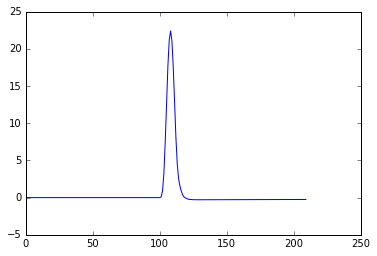

In [432]:
plt.plot(spe_v/units.mV)

In [433]:
spe_adc = FE.daq_decimator(1000.*units.MHZ, 40*units.MHZ, spe_v*FE.v_to_adc())

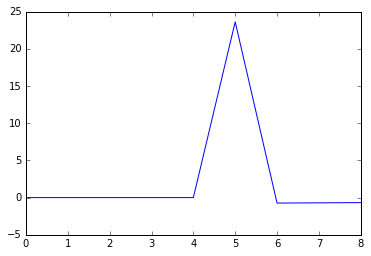

In [434]:
plt.plot(spe_adc)

In [436]:
np.sum(spe_adc[4:6])

23.621822991234684

### Deconvolution algorithm

The simplest version of the deconvolution algorithm (no noise)

In [339]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

## FEE filters

#### filter_fee : This function gives the coefficients needed to filter the input signal and emulate the effect of FEE
#### NB: a is adimensional, but b is given in ohms (it includes gain). Thus the output of the filter will be in voltage (input in current)

In [341]:
ipmt=-1
b,a = FE.filter_fee(fee, ipmt)

In [342]:
print('filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

filter parameters: a = [ 1.         -1.61087863  1.09765171 -0.78293344  0.31493115 -0.02845585
  0.0108042 ] b = [  1.05834516e+01   4.23338687e+01   5.29175691e+01   6.22138897e-04
  -5.29166359e+01  -4.23334954e+01  -1.05833894e+01] ohm


In [343]:
b,a = FE.filter_fee(fee, 1)

In [344]:
print('filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

filter parameters: a = [ 1.         -1.61116971  1.09783008 -0.78307492  0.31501785 -0.02846099
  0.01080735] b = [  1.05850149e+01   4.23401646e+01   5.29255999e+01   1.05115283e-03
  -5.29240232e+01  -4.23395339e+01  -1.05849097e+01] ohm


In [345]:
print("f_sample = {} Mhz".format(fee.f_sample/units.MHZ))

f_sample = 40.0 Mhz


In [346]:
def plot_filter(a,b, size_x=10, size_y=10):
    """
    Plots the filter
    """
    b = b/units.ohm
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6.5,0.4,40000)) 
    fig = plt.figure(figsize=(size_x, size_y))
    ax1 = fig.add_subplot(111)
    plt.semilogx(w*(fee.f_sample/units.hertz)/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.semilogx(w*(fee.f_sample/units.hertz)/(2*np.pi), angles,'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')

    plt.show()

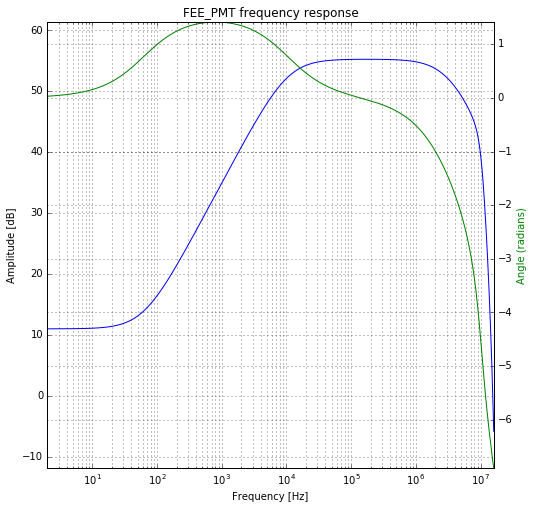

In [347]:
plot_filter(a,b,size_x=8, size_y=8)

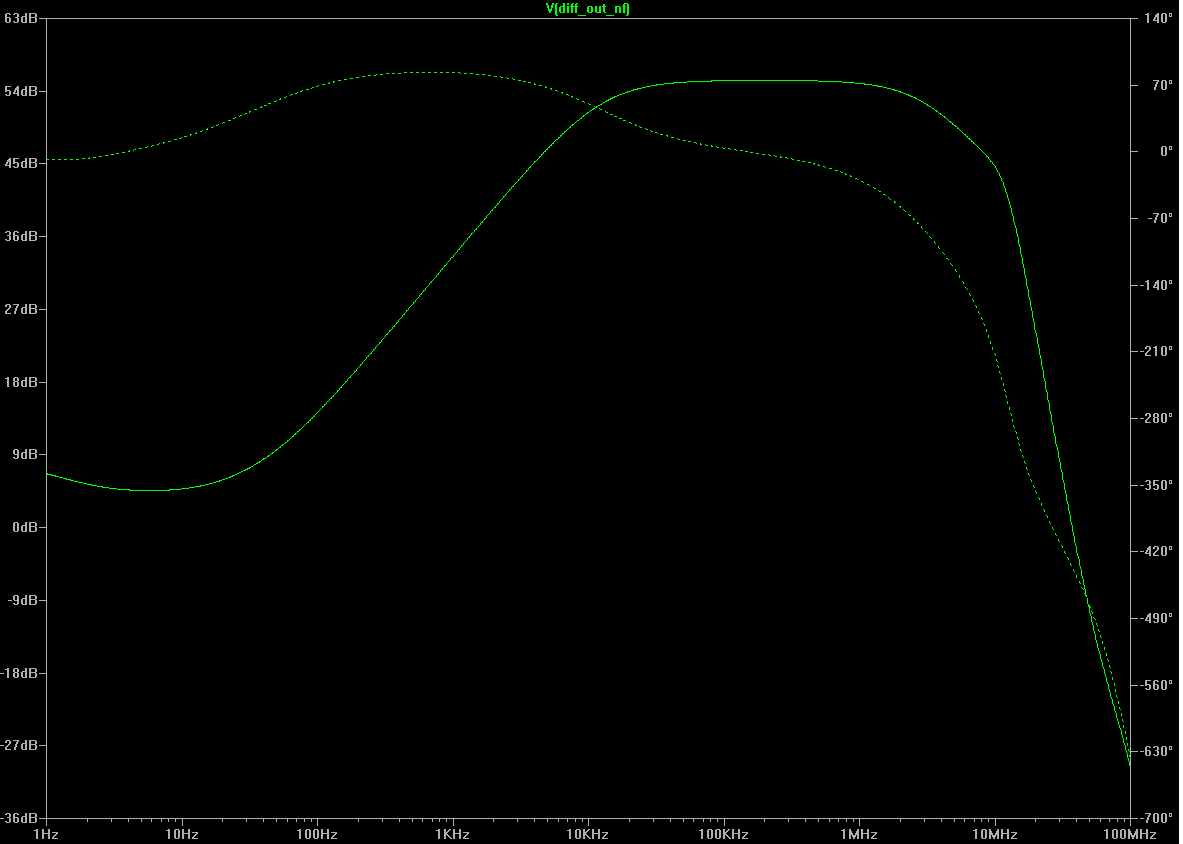

In [348]:
Image(filename = PATH + "FEE_PMT_freq_response_simulated_spice.png")

#### MATCH!!!   --VERY CLOSE TO THE SPICE SIMULATED ONE--

### =======   TEST WITHOUT NOISE   ========

In [349]:
def signal_i_th():
    """
    generates a "theoretical" current signal (signal_i)
    """
    return np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

In [350]:
signal_i = signal_i_th()

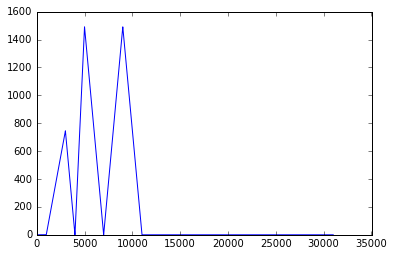

In [351]:
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())   #plot input signal in adc counts

### Effect of electronics 

1. Implemented by the funtion signal_v_fee(feep, signal_i), which takes a current signal and returns a voltage signal 

In [352]:
signal_out = FE.signal_v_fee(fee, signal_i, -1)

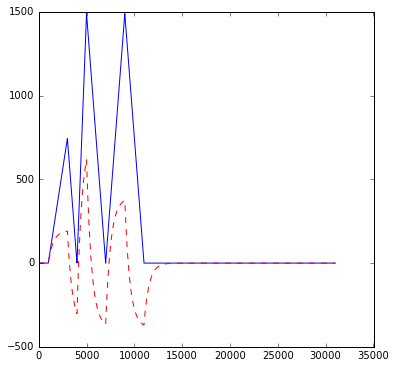

In [353]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(),'r--', linewidth=1)
plt.show()

### Deconvolution

In the absence of noise, a simple deconvolution (deconv_simple) is sufficient. 

In [354]:
print('deconvolution coefficient = {}'.format(fee.freq_LHPFd*np.pi))

deconvolution coefficient = 0.00192400951255


In [355]:
signal_r, acum = deconv_simple(signal_out*FE.v_to_adc(),coef=fee.freq_LHPFd*np.pi)

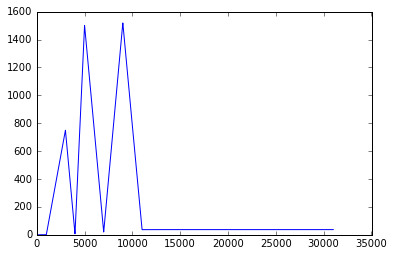

In [356]:
plt.plot(signal_r)   # in adc counts

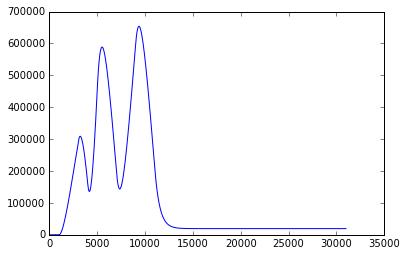

In [357]:
plt.plot(acum)  #the value of the accumulator

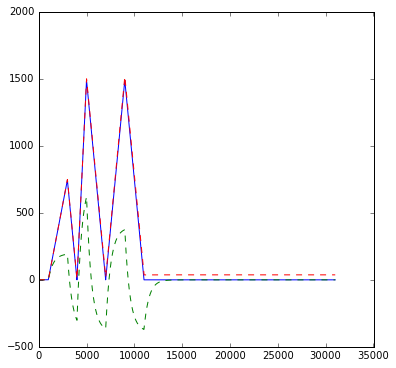

In [358]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(),'g--', linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r,'r--', linewidth=1)
plt.show()

#### NB: The deconvolution is good, but the recovered function shows a pedestal above the input function, which needs to be removed.

### Effect of pedestal in energy recovery

In [360]:
energy_mea=np.sum(signal_r[1000:11000])
energy_in=np.sum(signal_i*FE.i_to_adc())
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 6334738.56
Reconstructed Energy = 6499097.56906
Error in Energy Computation (%) = -2.5945665713


## DECONVOLUTION USING CLEANING FILTER + BLR

#### Cleaning the pedestal 

this is achieved by function *signal_v_clean(feep, signal_v)* which takes the signal produced by the convolution and removes the pedestal. 

In [361]:
signal_out_cf = FE.signal_clean(fee, signal_out, -1)

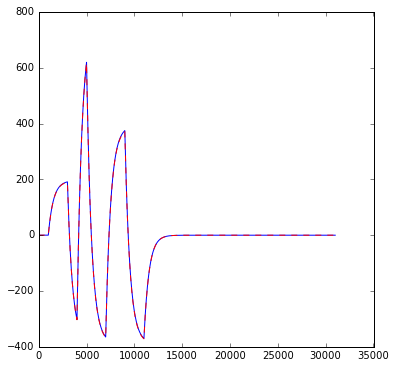

In [362]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(), linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_out_cf*FE.v_to_adc(),'r--', linewidth=1)
plt.show()

#### NB: The cleaned signal appears indistinguishible from the convoluted signal. However, when the signal is recovered the pedestal dissappears

In [363]:
signal_r2, acum = deconv_simple(signal_out_cf*FE.v_to_adc(),coef=fee.freq_LHPFd*np.pi)

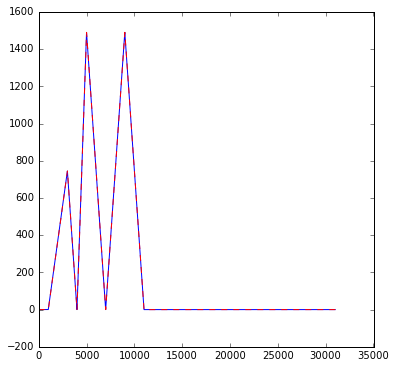

In [364]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),signal_r2,'r--', linewidth=1)
plt.show()

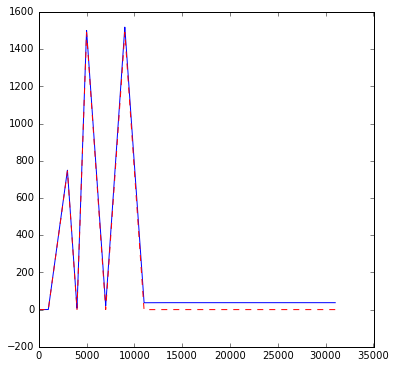

In [365]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_r, linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r2,'r--', linewidth=1)
plt.show()

In [367]:
energy_mea2=np.sum(signal_r2[1000:11000])
energy_in2=np.sum(signal_i*FE.i_to_adc())
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6334918.78314
Error in Energy Computation (%) = -0.00284499725187


## ======  TEST WITH NOISE and DAQ EFFECT ======= 

In [368]:
feepN = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
feepN


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         A1 = 59.6403 ohm,
         A2 =  9.7625,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         coeff_blr =  0.00192,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31,
         freq_LHPFd (PMTs) = [ 0.00051961  0.00051961  0.00051283  0.00050909  0.00049878  0.00052509
  0.00050706  0.00051314  0.00050951  0.00050698  0.0005014   0.00050813],
         coef_blr (PMTs)= [ 0.00163241  0.00163241  0.0016111   0.00159936  0.00156696  0.00164962
  0.00159296  0.00161207  0.00160068  0.00159272  0.00157519  0.00159632],
         freq_zero = 2.3514e-07,
         coeff_c = 1.8712e-06,
    

In [369]:
signal_outn = FE.signal_v_fee(feepN, signal_i, -1)  #this time with effect of noise

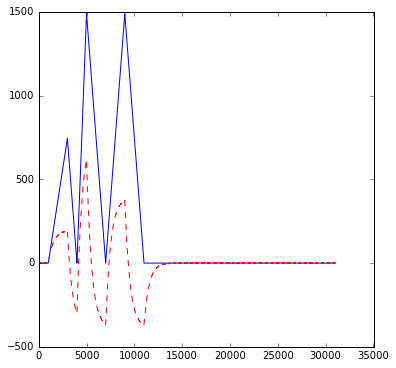

In [370]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),signal_outn*FE.v_to_adc(),'r--', linewidth=1)
plt.show()

In [371]:
print "Out Noise FEE (LSB_rms) =",np.std(signal_outn[25000:26000]*FE.v_to_adc(),ddof=1)

Out Noise FEE (LSB_rms) = 0.320759935014


#### NB: the nominal noise for FEE + PMT is 0.2 adc counts. One can tune the value of the noise up, but the order of magnitude is correct

### Now add the DAQ contribution

In [372]:
signal_outnd = FE.noise_adc(feepN, signal_outn*FE.v_to_adc())

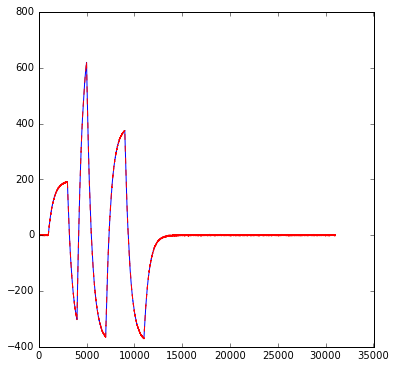

In [373]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_outn*FE.v_to_adc(), linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_outnd,'r--', linewidth=1)
plt.show()

In [374]:
print "Out TOTAL out noise (LSB_rms) =",np.std(signal_outnd[25000:26000],ddof=1)

Out TOTAL out noise (LSB_rms) = 0.879825873309


## Reconstruct with Cleaning Filter

In [375]:
signal_out_cf2 = FE.signal_clean(feepN, signal_outnd, -1)

In [376]:
signal_r3, acum = deconv_simple(signal_out_cf2,coef=feepN.freq_LHPFd*np.pi)

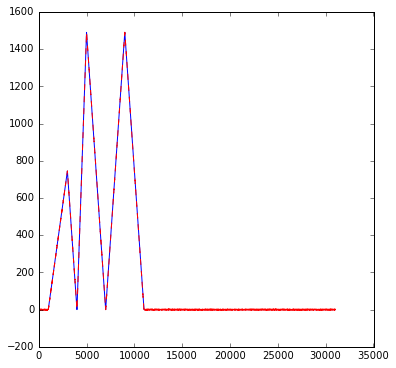

In [377]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),signal_r3,'r--', linewidth=1)
plt.show()

In [378]:
energy_mea2=np.sum(signal_r3[0:11000])
energy_in2=np.sum(signal_i[0:11000]*FE.i_to_adc())
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6335708.93706
Error in Energy Computation (%) = -0.0153183442388


### Deconvolution with measured coeficient values

pmt = -1, coeff_blr = 0.00192400951255, coeff_c = 1.87116159952e-06
Input Energy = 6334738.56
Reconstructed Energy = 6332680.90497
Error in Energy Computation (%) = 0.0324820829415


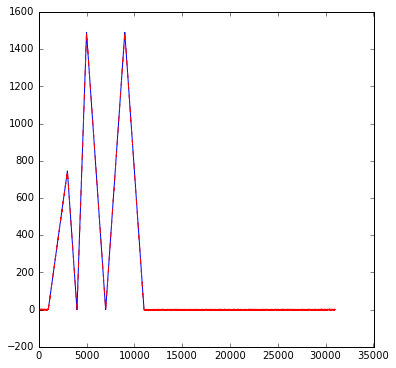

Press a key...
pmt = 0, coeff_blr = 0.001632411, coeff_c = 2.905447e-06
Input Energy = 6334738.56
Reconstructed Energy = 6341025.78332
Error in Energy Computation (%) = 0.099249925824


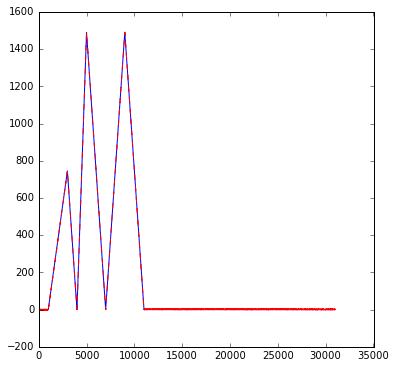

Press a key...
pmt = 1, coeff_blr = 0.001632411, coeff_c = 3.08e-06
Input Energy = 6334738.56
Reconstructed Energy = 6341441.09889
Error in Energy Computation (%) = 0.105806085413


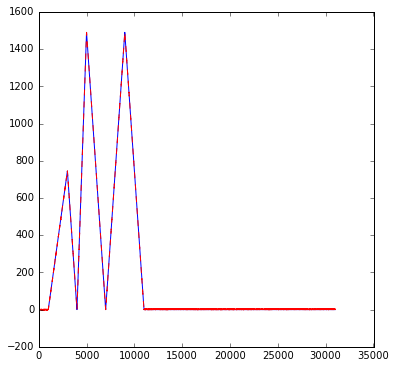

Press a key...
pmt = 2, coeff_blr = 0.001611104, coeff_c = 2.8006e-06
Input Energy = 6334738.56
Reconstructed Energy = 6340672.8763
Error in Energy Computation (%) = 0.0936789457292


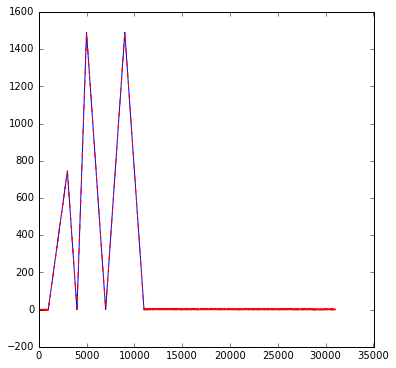

Press a key...
pmt = 3, coeff_blr = 0.001599356, coeff_c = 2.756265e-06
Input Energy = 6334738.56
Reconstructed Energy = 6341403.07105
Error in Energy Computation (%) = 0.105205779039


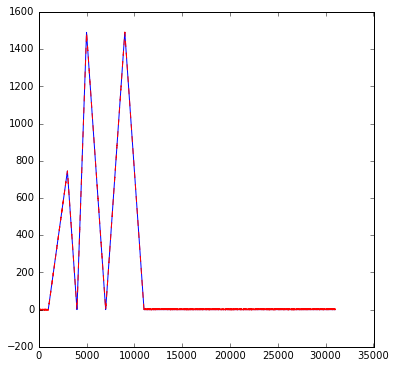

Press a key...
pmt = 4, coeff_blr = 0.001566958, coeff_c = 3.138766e-06
Input Energy = 6334738.56
Reconstructed Energy = 6341053.26752
Error in Energy Computation (%) = 0.0996837905105


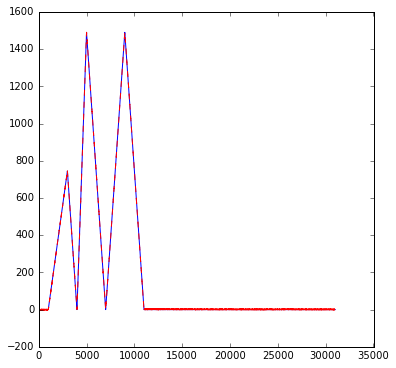

Press a key...
pmt = 5, coeff_blr = 0.001649618, coeff_c = 3.965176e-06
Input Energy = 6334738.56
Reconstructed Energy = 6342924.70728
Error in Energy Computation (%) = 0.129226284634


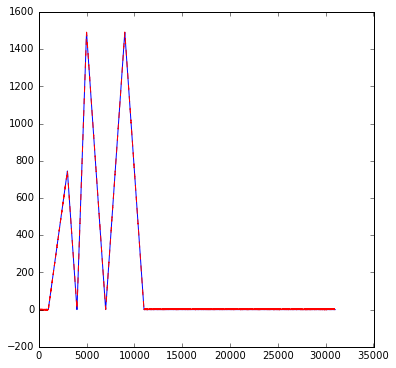

Press a key...
pmt = 6, coeff_blr = 0.001592963, coeff_c = 2.711e-06
Input Energy = 6334738.56
Reconstructed Energy = 6340419.29482
Error in Energy Computation (%) = 0.089675915839


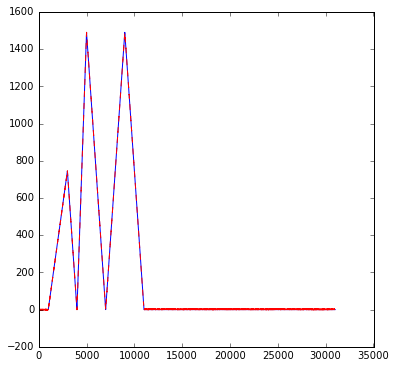

Press a key...
pmt = 7, coeff_blr = 0.001612068, coeff_c = 3.127641e-06
Input Energy = 6334738.56
Reconstructed Energy = 6341596.39138
Error in Energy Computation (%) = 0.10825752811


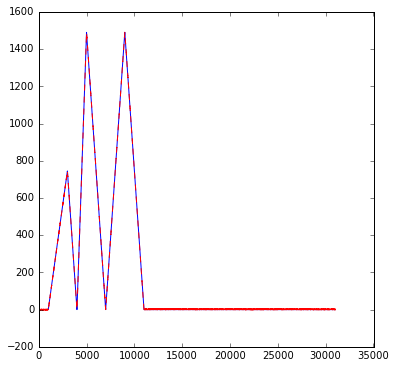

Press a key...
pmt = 8, coeff_blr = 0.001600683, coeff_c = 3.064543e-06
Input Energy = 6334738.56
Reconstructed Energy = 6342351.03689
Error in Energy Computation (%) = 0.120170340386


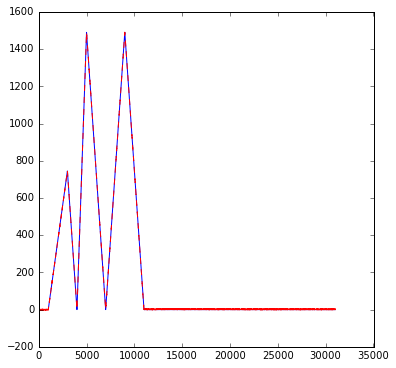

Press a key...
pmt = 9, coeff_blr = 0.001592718, coeff_c = 3.040463e-06
Input Energy = 6334738.56
Reconstructed Energy = 6340586.39935
Error in Energy Computation (%) = 0.0923138232008


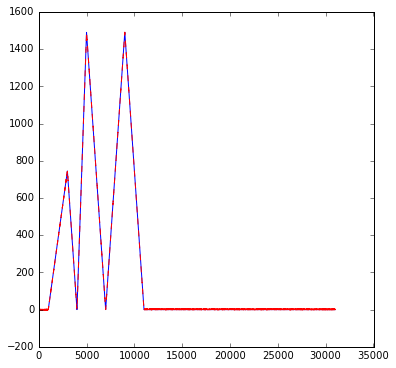

Press a key...
pmt = 10, coeff_blr = 0.001575192, coeff_c = 3.113604e-06
Input Energy = 6334738.56
Reconstructed Energy = 6341528.57757
Error in Energy Computation (%) = 0.107187021228


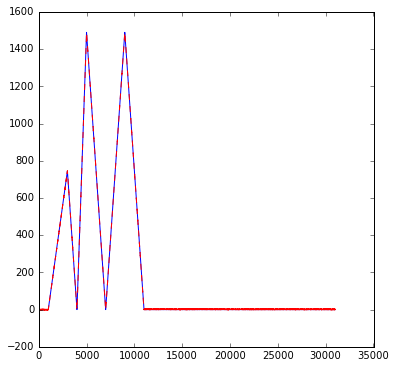

Press a key...
pmt = 11, coeff_blr = 0.001596322, coeff_c = 3.185979e-06
Input Energy = 6334738.56
Reconstructed Energy = 6342535.86259
Error in Energy Computation (%) = 0.123087993517


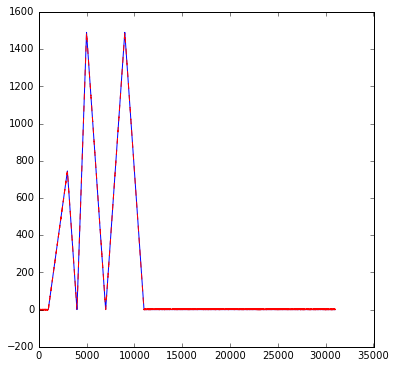

Press a key...


In [379]:
coef=feepN.freq_LHPFd*np.pi
coef_c = feepN.coeff_c
PMT = [-1,0,1,2,3,4,5,6,7,8,9,10,11]
feepN = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
for i in PMT:
    if i>-1: 
        coef = feepN.coeff_blr_pmt[i]
        coef_c = feepN.coeff_c_pmt[i]
    print('pmt = {}, coeff_blr = {}, coeff_c = {}'.format(i,coef,coef_c))
    signal_outn = FE.signal_v_fee(feepN, signal_i, i)   # convolution and noise FEE + PMT 
    signal_outnd = FE.noise_adc(feepN, signal_outn*FE.v_to_adc())  # NOISE DAQ
    signal_out_cf2 = FE.signal_clean(feepN, signal_outnd, i)  # cleaning.
    signal_r3, acum = deconv_simple(signal_out_cf2,coef=coef)
    energy_mea2=np.sum(signal_r3[0:11000])
    energy_in2=np.sum(signal_i[0:11000]*FE.i_to_adc())
    print('Input Energy = {}'.format(energy_in2))
    print('Reconstructed Energy = {}'.format(energy_mea2))
    print('Error in Energy Computation (%) = {}'.format(abs(energy_in2-energy_mea2)/energy_in2*100))
    plt.figure(figsize=(6, 6))
    plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
    plt.plot(range(0,np.size(signal_i),1),signal_r3,'r--', linewidth=1)
    plt.show()
    crf.wait()
    

### Deconvolute with a fixed value
(fix to nominal deconvolution value)

In [381]:
for i in range(12):
    print('pmt = {}, coeff_blr = {}'.format(i,feepN.coeff_blr_pmt[i]))
    signal_outn = FE.signal_v_fee(feepN, signal_i, i)   # convolution and noise FEE + PMT 
    signal_outnd = FE.noise_adc(feepN, signal_outn*FE.v_to_adc())  # NOISE DAQ
    signal_out_cf2 = FE.signal_clean(feepN, signal_outnd, i)  # cleaning.
    signal_r3, acum = deconv_simple(signal_out_cf2,coef=feepN.freq_LHPFd*np.pi)
    energy_mea2=np.sum(signal_r3[0:11000])
    energy_in2=np.sum(signal_i[0:11000]*FE.i_to_adc())
    print('Input Energy = {}'.format(energy_in2))
    print('Reconstructed Energy = {}'.format(energy_mea2))
    print('Error in Energy Computation (%) = {}'.format(abs(energy_in2-energy_mea2)/energy_in2*100))

pmt = 0, coeff_blr = 0.001632411
Input Energy = 6334738.56
Reconstructed Energy = 7427840.34083
Error in Energy Computation (%) = 17.2556731502
pmt = 1, coeff_blr = 0.001632411
Input Energy = 6334738.56
Reconstructed Energy = 7427892.13448
Error in Energy Computation (%) = 17.2564907633
pmt = 2, coeff_blr = 0.001611104
Input Energy = 6334738.56
Reconstructed Energy = 7519665.62112
Error in Energy Computation (%) = 18.7052243735
pmt = 3, coeff_blr = 0.001599356
Input Energy = 6334738.56
Reconstructed Energy = 7571829.13268
Error in Energy Computation (%) = 19.5286760608
pmt = 4, coeff_blr = 0.001566958
Input Energy = 6334738.56
Reconstructed Energy = 7721973.99331
Error in Energy Computation (%) = 21.8988584954
pmt = 5, coeff_blr = 0.001649618
Input Energy = 6334738.56
Reconstructed Energy = 7355010.43352
Error in Energy Computation (%) = 16.1059823362
pmt = 6, coeff_blr = 0.001592963
Input Energy = 6334738.56
Reconstructed Energy = 7603197.40407
Error in Energy Computation (%) = 20.023

## Statistics

In [383]:
n = 1000
recons_a = np.zeros(n)
ipmt = -1
for i in range(0,n):
    signal_outn = FE.signal_v_fee(feepN, signal_i, ipmt)   # convolution and noise FEE + PMT 
    signal_outnd = FE.noise_adc(feepN, signal_outn*FE.v_to_adc())  # NOISE DAQ
    signal_out_cf2 = FE.signal_clean(feepN, signal_outnd, ipmt)  # cleaning.
    signal_r3, acum = deconv_simple(signal_out_cf2,coef=feepN.freq_LHPFd*np.pi)
    recons_a[i]=np.sum(signal_r3[1000:11000])

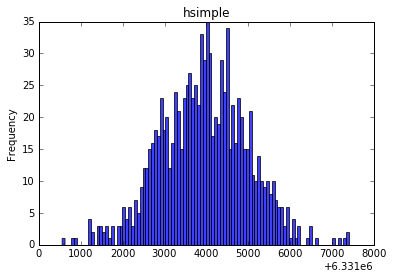

In [384]:
mpl.histo(recons_a,100)

In [385]:
LSB_DAQ = 2.0/(2**12)
SPE = 20

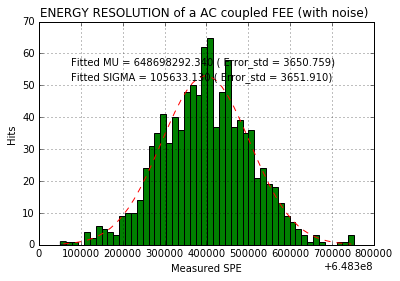

('Fitted A = ', 53.023010205832243, '( Error_std=', 1.5871380854379551, ')')
('Fitted MU = ', 648698292.3400203, '( Error_std=', 3650.7590524301763, ')')
('FItted SIGMA = ', 105633.12950556052, '( Error_std=', 3651.9101354839604, ')')
ENERGY RESOLUTION (%) =  0.0382670738106


In [386]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,8,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

In [387]:
n = 1000
recons_a = np.zeros(n)
ipmt = 0
for i in range(0,n):
    signal_outn = FE.signal_v_fee(feepN, signal_i, ipmt)   # convolution and noise FEE + PMT 
    signal_outnd = FE.noise_adc(feepN, signal_outn*FE.v_to_adc())  # NOISE DAQ
    signal_out_cf2 = FE.signal_clean(feepN, signal_outnd, ipmt)  # cleaning.
    signal_r3, acum = deconv_simple(signal_out_cf2,coef=feepN.coeff_blr_pmt[ipmt])
    recons_a[i]=np.sum(signal_r3[1000:11000])

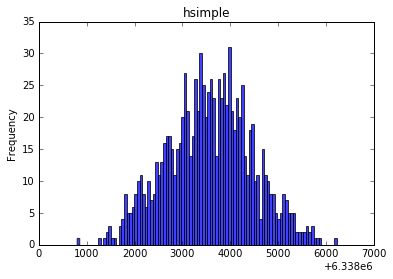

In [388]:
mpl.histo(recons_a,100)

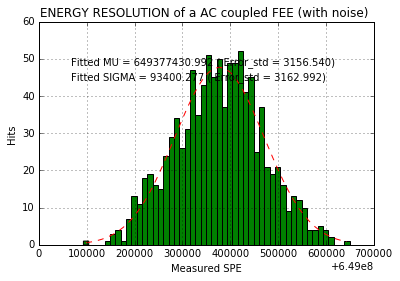

('Fitted A = ', 47.733611320044027, '( Error_std=', 1.3975563025788234, ')')
('Fitted MU = ', 649377430.99244869, '( Error_std=', 3156.5397985319955, ')')
('FItted SIGMA = ', 93400.27696292683, '( Error_std=', 3162.9917080764899, ')')
ENERGY RESOLUTION (%) =  0.033800166188


In [389]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,8,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

In [390]:
n = 1000
recons_a = np.zeros(n)
ipmt = 11
for i in range(0,n):
    signal_outn = FE.signal_v_fee(feepN, signal_i, ipmt)   # convolution and noise FEE + PMT 
    signal_outnd = FE.noise_adc(feepN, signal_outn*FE.v_to_adc())  # NOISE DAQ
    signal_out_cf2 = FE.signal_clean(feepN, signal_outnd, ipmt)  # cleaning.
    signal_r3, acum = deconv_simple(signal_out_cf2,coef=feepN.coeff_blr_pmt[ipmt])
    recons_a[i]=np.sum(signal_r3[1000:11000])

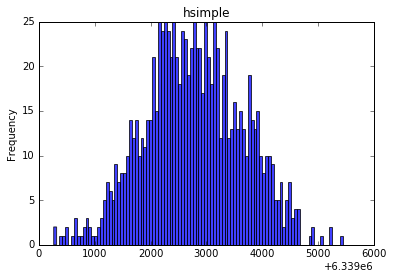

In [391]:
mpl.histo(recons_a,100)

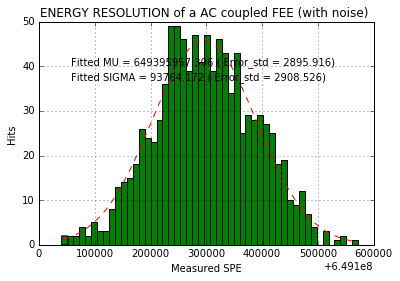

('Fitted A = ', 45.765027998098915, '( Error_std=', 1.2248807776068928, ')')
('Fitted MU = ', 649395957.30642092, '( Error_std=', 2895.9157001108761, ')')
('FItted SIGMA = ', 93764.17240043325, '( Error_std=', 2908.5256734474724, ')')
ENERGY RESOLUTION (%) =  0.0339308864895


In [392]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,8,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

#### Simulation/deconvolution works now for each individual PMT